<a href="https://colab.research.google.com/github/kishore779/Pytorch_Programming/blob/main/02_neural_network_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 02 Neural Network classification with PyTorch

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import sklearn

In [2]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state = 42)


In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples : {X[:5]}")
print(f"First 5 labels : {y[:5]}")

First 5 samples : [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 labels : [1 1 1 1 0]


In [5]:
import pandas as pd

circles = pd.DataFrame({"X1" : X[:,0],
                        "X2" : X[:,1],
                        "label" : y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


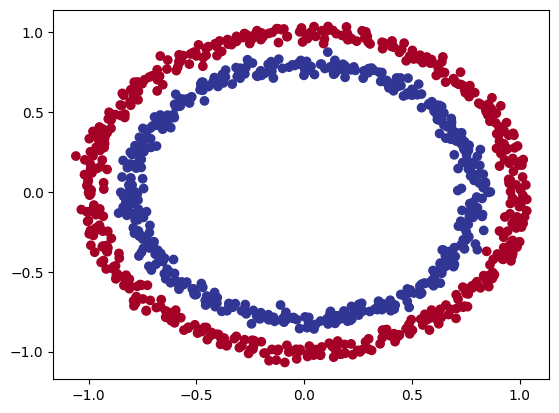

In [6]:
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu);

### 1.1 Check input and output shapes

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

##Turn data into tensor and split the data

In [8]:
import torch
torch.__version__

'2.9.0+cu126'

In [9]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [10]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5],y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [11]:
#Spilt the data into train and test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state= 42)
len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

In [12]:
y_train[:5]

tensor([1., 0., 0., 0., 1.])

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Building a model

In [14]:
from sklearn import datasets

class CircularModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1 = nn.Linear(in_features = 2, out_features = 5)
    self.layer2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, x):
    return self.layer2(self.layer1(x))

model_0 = CircularModelV0().to(device)
model_0

CircularModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
next(model_0.parameters()).device

device(type='cuda', index=0)

## By using the Sequential module

 * model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
)
model_0


In [16]:
model_0.state_dict()

OrderedDict([('layer1.weight',
              tensor([[-0.6820,  0.1047],
                      [ 0.6317,  0.5000],
                      [-0.4283, -0.0095],
                      [ 0.2223,  0.4381],
                      [-0.5893,  0.4014]], device='cuda:0')),
             ('layer1.bias',
              tensor([-0.3477,  0.2253, -0.4610, -0.0214, -0.5700], device='cuda:0')),
             ('layer2.weight',
              tensor([[-0.1703, -0.1514, -0.1069,  0.4421,  0.3666]], device='cuda:0')),
             ('layer2.bias', tensor([-0.2610], device='cuda:0'))])

In [17]:
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
untrained_preds[:10]

tensor([[-0.2162],
        [-0.1674],
        [-0.4470],
        [-0.1504],
        [-0.6104],
        [-0.5794],
        [-0.3126],
        [-0.4095],
        [-0.4397],
        [-0.1660]], device='cuda:0')

## Set up a loss function and optimizer

In [18]:
##  loss_fn = nn.BCELoss()

loss_fn = nn.BCEWithLogitsLoss() # sigmoid fn activation

optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr=0.1)

In [19]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

## Training the model using the known steps from prev section

In [20]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.2162],
        [-0.1674],
        [-0.4470],
        [-0.1504],
        [-0.6104]], device='cuda:0')

In [21]:
## use sigmoid activation fn

y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4462],
        [0.4582],
        [0.3901],
        [0.4625],
        [0.3520]], device='cuda:0')

In [22]:
y_preds = torch.round(y_pred_probs)

y_pred_label = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

print(torch.eq(y_preds.squeeze(),y_pred_label.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 0.], device='cuda:0')

## Building a training and Testing Loop

In [23]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_0.train()

  # forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # calculate loss and acc
  loss = loss_fn(y_logits,
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
  # optimizer zero_grad
  optimizer.zero_grad()

  # loss backward
  loss.backward()

  # optimizer step
  optimizer.step()

  ## testing
  model_0.eval()
  with torch.inference_mode():

    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)
  if epoch % 10 == 0:
    print(f"Epoch:{epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test_loss: {test_loss:.5f} | Test_acc: {test_acc:.2f}%")


Epoch:0 | Loss: 0.71590 | Acc: 50.00% | Test_loss: 0.71763 | Test_acc: 50.00%
Epoch:10 | Loss: 0.70133 | Acc: 50.00% | Test_loss: 0.70578 | Test_acc: 49.00%
Epoch:20 | Loss: 0.69653 | Acc: 45.62% | Test_loss: 0.70182 | Test_acc: 47.00%
Epoch:30 | Loss: 0.69482 | Acc: 49.12% | Test_loss: 0.70025 | Test_acc: 46.00%
Epoch:40 | Loss: 0.69413 | Acc: 49.62% | Test_loss: 0.69940 | Test_acc: 45.50%
Epoch:50 | Loss: 0.69379 | Acc: 49.88% | Test_loss: 0.69879 | Test_acc: 47.00%
Epoch:60 | Loss: 0.69359 | Acc: 50.12% | Test_loss: 0.69829 | Test_acc: 46.00%
Epoch:70 | Loss: 0.69345 | Acc: 50.25% | Test_loss: 0.69786 | Test_acc: 46.00%
Epoch:80 | Loss: 0.69335 | Acc: 50.75% | Test_loss: 0.69749 | Test_acc: 45.50%
Epoch:90 | Loss: 0.69327 | Acc: 51.00% | Test_loss: 0.69716 | Test_acc: 46.00%


In [24]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("its already there")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)
from helper_functions import plot_predictions, plot_decision_boundary

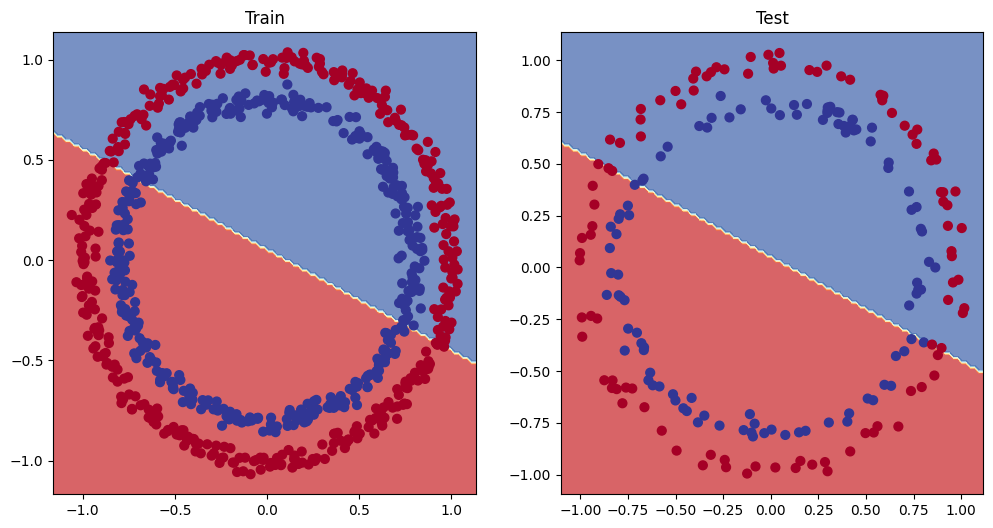

In [25]:
# plot decision boundry

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

##5.1 Preparing data to see if our model can fit a straight line

to troubleshoot the problem

In [27]:
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_reg = torch.arange(start,end,step).unsqueeze(dim=1)
y_reg = weight * X_reg + bias

print(len(X_reg))
X_reg[:5],y_reg[:5]


100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [29]:
#crate terain and test

train_spilt = int(0.8 * len(X_reg))
X_train_reg, y_train_reg = X_reg[:train_spilt],y_reg[:train_spilt]
X_test_reg, y_test_reg = X_reg[train_spilt:],y_reg[train_spilt:]

len(X_train_reg), len(y_train_reg), len(X_test_reg), len(y_test_reg)

(80, 80, 20, 20)

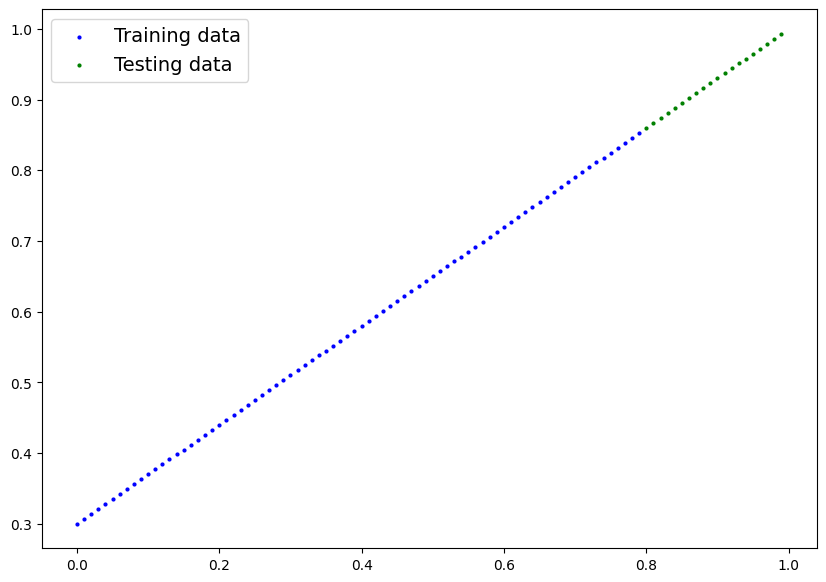

In [31]:
plot_predictions(train_data=X_train_reg,
                 train_labels=y_train_reg,
                 test_data=X_test_reg,
                 test_labels=y_test_reg)

## 5.2 Adjusting the model_1 to fit the straight line

In [37]:
##same architecture as model_0 by nn.squential()

model_1 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1),
).to(device)

model_1

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [44]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params= model_1.parameters(),
                            lr = 0.01)

In [46]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train_reg, y_train_reg = X_train_reg.to(device), y_train_reg.to(device)
X_test_reg, y_test_reg = X_test_reg.to(device), y_test_reg.to(device)

for epoch in range(epochs):

  model_1.train()
  y_pred = model_1(X_train_reg)
  loss = loss_fn(y_pred, y_train_reg)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test_reg)
    test_loss = loss_fn(test_pred, y_test_reg)
  if epoch % 100 == 0:
    print(f"Epoch:{epoch} | Loss: {loss:.5f} | Test_loss: {test_loss:.5f}")

Epoch:0 | Loss: 0.00544 | Test_loss: 0.01222
Epoch:100 | Loss: 0.00517 | Test_loss: 0.01193
Epoch:200 | Loss: 0.00577 | Test_loss: 0.01232
Epoch:300 | Loss: 0.00550 | Test_loss: 0.01199
Epoch:400 | Loss: 0.00525 | Test_loss: 0.01228
Epoch:500 | Loss: 0.00555 | Test_loss: 0.01266
Epoch:600 | Loss: 0.00557 | Test_loss: 0.01233
Epoch:700 | Loss: 0.00531 | Test_loss: 0.01200
Epoch:800 | Loss: 0.00533 | Test_loss: 0.01298
Epoch:900 | Loss: 0.00535 | Test_loss: 0.01265


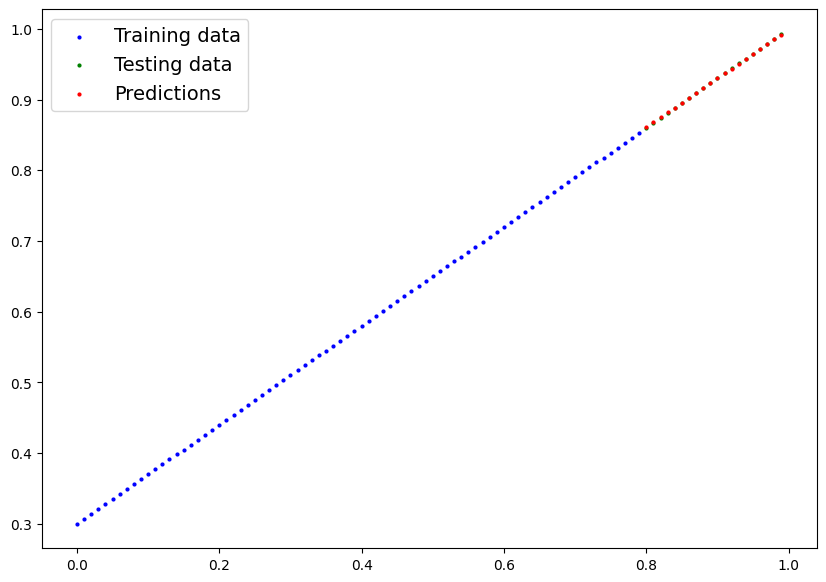

In [51]:
model_1.eval()
with torch.inference_mode():
  y_preds_ = model_1(X_test_reg)

  plot_predictions(train_data=X_train_reg.cpu(),
                   train_labels=y_train_reg.cpu(),
                   test_data=X_test_reg.cpu(),
                   test_labels=y_test_reg.cpu(),
                   predictions=y_preds_.cpu())

 ## By the non Linearity Funtions we use that can improve the accuracy

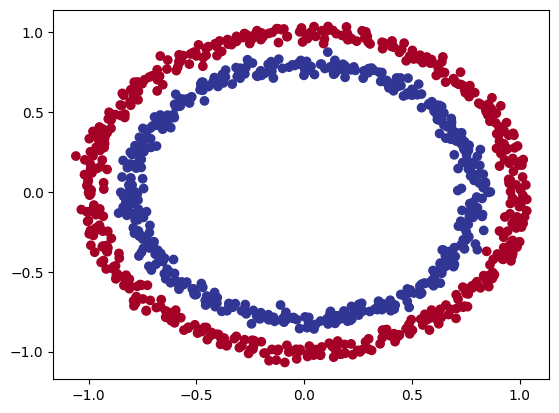

In [53]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import sklearn

from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state = 42)
plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.RdYlBu);

In [54]:
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

## We build a model with ReLU function

In [55]:
## model with non-linearity

class CircularModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=10)
    self.layer2 = nn.Linear(in_features =10, out_features =10)
    self.layer3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model_2 = CircularModelV2().to(device)
model_2

CircularModelV2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [61]:
## loss fn and optimizer

loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(model_2.parameters(),
                            lr=0.1)

## Training and testing with ReLU

In [62]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):

  model_2.train()
  y_logits = model_2(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_preds)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_2.eval()
  with torch.inference_mode():
    test_logits = model_2(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred = test_preds)

  if epoch % 100 == 0:
    print(f"Epoch:{epoch} | Loss:{loss:.5f} | Acc:{acc:.5f}% | test_loss:{test_loss:.5f} | test_acc:{test_acc:.5f}%")

Epoch:0 | Loss:0.69115 | Acc:53.00000% | test_loss:0.69102 | test_acc:52.50000%
Epoch:100 | Loss:0.68977 | Acc:53.37500% | test_loss:0.68939 | test_acc:55.00000%
Epoch:200 | Loss:0.68795 | Acc:53.00000% | test_loss:0.68723 | test_acc:56.00000%
Epoch:300 | Loss:0.68516 | Acc:52.75000% | test_loss:0.68411 | test_acc:56.50000%
Epoch:400 | Loss:0.68101 | Acc:52.75000% | test_loss:0.67940 | test_acc:56.50000%
Epoch:500 | Loss:0.67513 | Acc:54.50000% | test_loss:0.67283 | test_acc:56.00000%
Epoch:600 | Loss:0.66656 | Acc:58.37500% | test_loss:0.66318 | test_acc:59.00000%
Epoch:700 | Loss:0.65154 | Acc:64.00000% | test_loss:0.64752 | test_acc:67.50000%
Epoch:800 | Loss:0.62352 | Acc:74.00000% | test_loss:0.62137 | test_acc:79.00000%
Epoch:900 | Loss:0.56799 | Acc:87.87500% | test_loss:0.57362 | test_acc:86.50000%


In [63]:
model_2.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_2(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 1., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

In [64]:
model_2.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.7236,  0.9530],
                      [-0.1983,  0.8373],
                      [-0.1549,  0.1427],
                      [-1.1908,  0.1507],
                      [ 0.5726, -1.5322],
                      [ 0.7304,  0.1907],
                      [ 0.8964,  0.3062],
                      [ 0.3410, -0.0998],
                      [ 0.7157,  0.3868],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('layer1.bias',
              tensor([-0.3578, -0.2860, -0.2872,  0.2137, -0.4831, -0.3273, -0.3450, -0.4252,
                      -0.2110, -0.6984], device='cuda:0')),
             ('layer2.weight',
              tensor([[ 9.5487e-02, -4.0612e-01,  2.4414e-01, -8.9958e-02, -3.1219e-01,
                        8.7004e-02, -6.9794e-02,  2.5550e-01, -6.9122e-02, -9.9730e-02],
                      [ 9.6775e-01,  5.4086e-01,  1.3309e-01,  9.7995e-01,  1.1689e+00,
                        3.6195e-01,  7.3834e-01,  

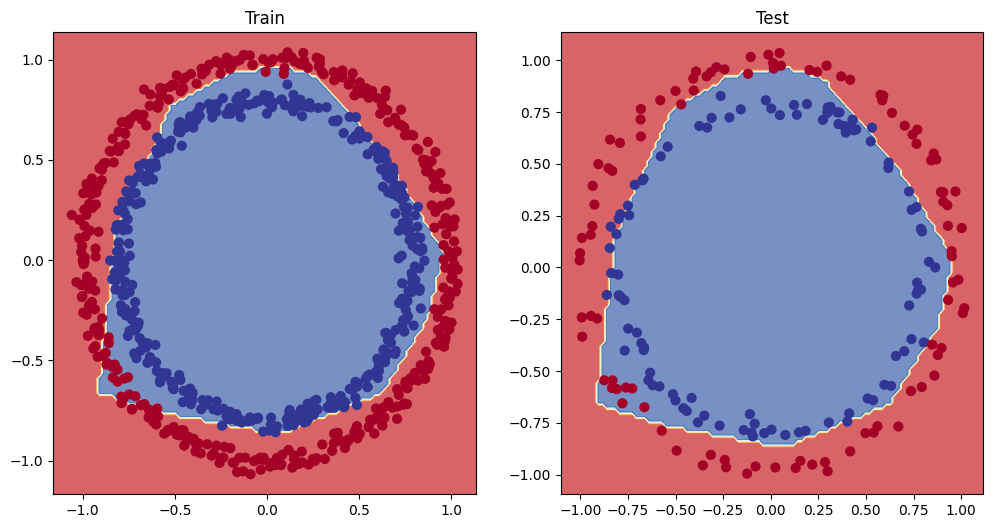

In [65]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_2,X_test, y_test)